In [1]:
import pandas as pd

# Load the data
file_path = 'predictionChallenge.csv'
data = pd.read_csv(file_path)
data.head()


,ID,name,host [id],host-name,neighbourhood group,neighbourhood,latitude,longitude,room and type,minimum nights,number_of_reviews,last_review,reviews_per_month,floor,noise(dB),Price($),mean_review_score,Deal Quality
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,1,9,10/19/2018,0.21,24,66.3829,149,3.0,Unknown
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,1,45,5/21/2019,0.38,16,60.8084,225,4.5,Bad
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,3,0,NaN,NaN,10,67.2671,150,5.0,Unknown
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,1,270,7/5/2019,4.64,15,57.8584,89,3.5,Good
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,10,9,11/19/2018,0.10,15,67.5878,80,2.5,Unknown


In [2]:
# Check for missing values in the dataset
missing_values = data.isnull().sum()

# Data types of the columns
data_types = data.dtypes

missing_values, data_types


(ID                         0
 name                      16
 host [id]                  0
 host-name                 21
 neighbourhood group        0
 neighbourhood              0
 latitude                   0
 longitude                  0
 room and type              0
 minimum nights             0
 number_of_reviews          0
 last_review            10052
 reviews_per_month      10052
 floor                      0
 noise(dB)                  0
 Price($)                   0
 mean_review_score          0
 Deal Quality               0
 dtype: int64,
 ID                       int64
 name                    object
 host [id]                int64
 host-name               object
 neighbourhood group     object
 neighbourhood           object
 latitude               float64
 longitude              float64
 room and type           object
 minimum nights           int64
 number_of_reviews        int64
 last_review             object
 reviews_per_month      float64
 floor                    int

In [3]:
# Fill missing values for 'name' and 'host-name' with a placeholder
data['name'].fillna('No name', inplace=True)
data['host-name'].fillna('No host name', inplace=True)

# Fill missing values for 'reviews_per_month' with 0
data['reviews_per_month'].fillna(0, inplace=True)

data['last_review'] = pd.to_datetime(data['last_review'], errors='coerce')
data['last_review'].fillna(pd.Timestamp('1900-01-01'), inplace=True)

# Check the dataset after the cleaning
data[['name', 'host-name', 'last_review', 'reviews_per_month']].head(), data.dtypes


(                                               name    host-name last_review  \
 0                Clean & quiet apt home by the park         John  2018-10-19   
 1                             Skylit Midtown Castle     Jennifer  2019-05-21   
 2               THE VILLAGE OF HARLEM....NEW YORK !    Elisabeth  1900-01-01   
 3                   Cozy Entire Floor of Brownstone  LisaRoxanne  2019-07-05   
 4  Entire Apt: Spacious Studio/Loft by central park        Laura  2018-11-19   
 
    reviews_per_month  
 0               0.21  
 1               0.38  
 2               0.00  
 3               4.64  
 4               0.10  ,
 ID                              int64
 name                           object
 host [id]                       int64
 host-name                      object
 neighbourhood group            object
 neighbourhood                  object
 latitude                      float64
 longitude                     float64
 room and type                  object
 minimum nights 

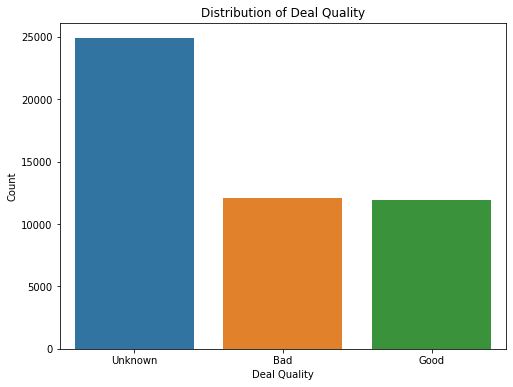

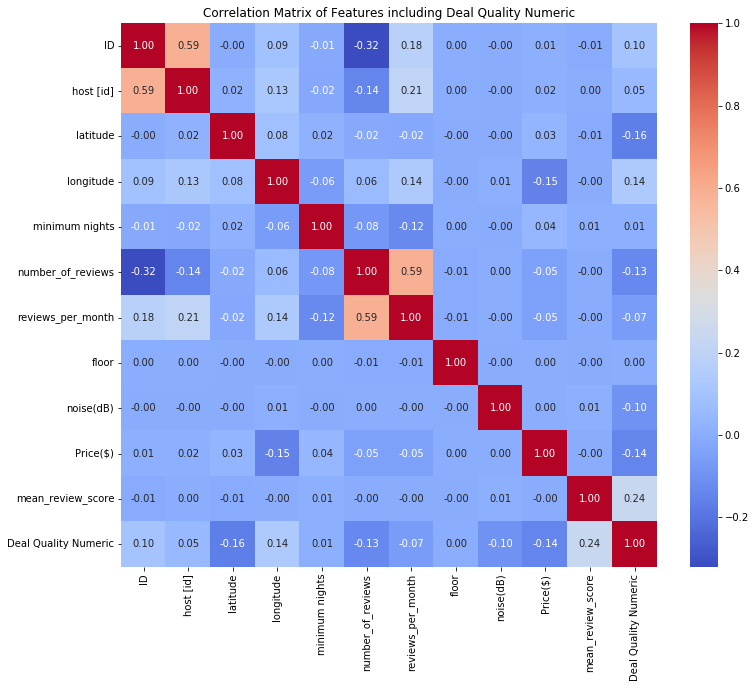

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of the target variable "Deal Quality"
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Deal Quality')
plt.title('Distribution of Deal Quality')
plt.xlabel('Deal Quality')
plt.ylabel('Count')
plt.show()

# Correlations of numerical features with the target variable
deal_quality_numeric = data['Deal Quality'].map({'Good': 1, 'Bad': -1, 'Unknown': 0})
data_temp = data.copy()
data_temp['Deal Quality Numeric'] = deal_quality_numeric

# Correlation matrix
correlation_matrix = data_temp.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features including Deal Quality Numeric')
plt.show()


In [5]:
from datetime import datetime

# Current date for reference
current_date = max(data['last_review'].max(), pd.Timestamp(datetime.now().strftime('%Y-%m-%d')))

# Calculate the duration since the last review in days
data['days_since_last_review'] = (current_date - data['last_review']).dt.days

# Review frequency: Total reviews divided by the number of months the listing has been active
data['review_frequency'] = data['number_of_reviews'] / data['reviews_per_month'].replace(0, 1)

# Price to quality ratio: Price($) divided by mean_review_score
data['price_quality_ratio'] = data['Price($)'] / (data['mean_review_score'] + 1)

data[['days_since_last_review', 'review_frequency', 'price_quality_ratio']].describe()


,days_since_last_review,review_frequency,price_quality_ratio
count,48895.000000,48895.000000,48895.000000
mean,10874.120421,21.917999,49.443377
std,17533.112116,22.816250,94.868073
min,1680.000000,0.000000,0.000000
25%,1699.000000,1.470588,18.333333
50%,1866.000000,14.705882,31.666667
75%,2881.000000,35.897436,55.333333
max,45332.000000,128.571429,6666.666667


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Dropping columns 
model_data = data.drop(['ID', 'name', 'host [id]', 'host-name', 'last_review'], axis=1)

# Encoding categorical variables
label_encoder = LabelEncoder()
categorical_cols = ['neighbourhood group', 'neighbourhood', 'room and type', 'Deal Quality']

for col in categorical_cols:
    model_data[col] = label_encoder.fit_transform(model_data[col])

# Splitting the data into features and target variable
X = model_data.drop('Deal Quality', axis=1)
y = model_data['Deal Quality']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Checking the shapes of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((39116, 15), (9779, 15), (39116,), (9779,))

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the testing set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

accuracy, classification_rep


(0.9985683607730852,
 '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00      2407\n           1       1.00      1.00      1.00      2347\n           2       1.00      1.00      1.00      5025\n\n    accuracy                           1.00      9779\n   macro avg       1.00      1.00      1.00      9779\nweighted avg       1.00      1.00      1.00      9779\n')